<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>

</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 1
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [18]:
name = "MohammadParsa Dini"
studentId = "400101204"

It is recommended to open this notebook in Google Colab from [here](https://colab.research.google.com/drive/1tPrFiVeEtt76GIoImPOuv7NA9hKorlue?usp=sharing) and create a copy. You can comment your questions on the notebook as well.

In this exercise we want to gain hands-on experience with Normalizing Flow Models.
1. We want to implement a simple flow model from scratch. (GPU not required)
2. We will use a flow model to perform image in-painting. (GPU recommended)

# Section 1: Flow From Scratch

In [19]:
# @title imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torchvision as tv

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # you can change this if you like

One of the challenges in creating flow models is creating invertible transformations. Also we would like it if computation of their inverse and/or the log determinant of their jacobian were simple.

In [21]:
# @title base transform abstract class

class InverseNotAvailable(Exception):
    """Exception to be thrown when a transform does not have an inverse."""

    pass

class Transform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise InverseNotAvailable()


First we can create a random permutation transform

In [22]:
class PermutationTransform(Transform):
    def __init__(self, num_features):
        super().__init__()
        permutation = torch.randperm(num_features)
        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        return inputs[:, self.permutation], 0  # Log-det is zero

    def inverse(self, inputs, context=None):
        return inputs[:, self.inverse_permutation]

Now  lets create a simple Coupling Transform.

In [23]:
class CouplingTransform(Transform):
    def __init__(self, mask, hidden_dims, s_net_f=None, t_net_f=None):
        super(CouplingTransform, self).__init__()

        mask = torch.as_tensor(mask, dtype=torch.float32)
        if mask.dim() != 1:
            raise ValueError("Mask must be a 1-dim tensor.")
        if mask.numel() <= 0:
            raise ValueError("Mask can't be empty.")

        self.register_buffer('mask', mask)

        self.num_features = self.mask.numel()
        features_vector = torch.arange(self.num_features)

        # Define input and output dimensions based on the mask
        self.input_dim = int((self.mask <= 0).sum())  # Features not transformed
        self.output_dim = int((self.mask > 0).sum())  # Features to transform

        # Ensure the scaling and translation networks are created properly
        self.s_net = s_net_f(self.input_dim, self.output_dim, hidden_dims) if s_net_f else self._default_net(self.input_dim, self.output_dim, hidden_dims)
        self.t_net = t_net_f(self.input_dim, self.output_dim, hidden_dims) if t_net_f else self._default_net(self.input_dim, self.output_dim, hidden_dims)

    def _default_net(self, input_dim, output_dim, hidden_dims):
        """Default MLP for scaling or translation networks."""
        if isinstance(hidden_dims, int):  # If hidden_dims is an int, make it a list
            hidden_dims = [hidden_dims]
        layers = []
        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:  # Add activation for all but the last layer
                layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, inputs, context=None):
        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")

        if inputs.shape[1] != self.num_features:
            raise ValueError(
                f"Expected features = {self.num_features}, got {inputs.shape[1]}."
            )

        # Split the input based on the mask
        x_untransformed = inputs[:, self.mask <= 0]
        x_transformed = inputs[:, self.mask > 0]

        # Compute scaling (s) and translation (t) for the untransformed part
        s = self.s_net(x_untransformed)
        t = self.t_net(x_untransformed)

        # Apply the transformations (scaling and translation)
        z_transformed = x_transformed * torch.exp(s) + t

        # Concatenate transformed and untransformed parts
        z = torch.cat([x_untransformed, z_transformed], dim=1)

        # Log determinant of Jacobian
        log_det_J = s.sum(dim=1)

        return z, log_det_J

    def inverse(self, inputs, context=None):
        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")

        if inputs.shape[1] != self.num_features:
            raise ValueError(
                f"Expected features = {self.num_features}, got {inputs.shape[1]}."
            )

        # Split the input based on the mask
        x_untransformed = inputs[:, self.mask <= 0]
        x_transformed = inputs[:, self.mask > 0]

        # Compute scaling (s) and translation (t) for the untransformed part
        s = self.s_net(x_untransformed)
        t = self.t_net(x_untransformed)

        # Apply the inverse transformations (inverse scaling and translation)
        z_transformed = (x_transformed - t) * torch.exp(-s)

        # Concatenate untransformed and inverse transformed parts
        z = torch.cat([x_untransformed, z_transformed], dim=1)

        return z

In this step we want to implement a simple Normalizing Flow Model similar to RealNVP. First we should create our base flow module. This base module is flexible in that it can have any number of transformations that inherit from the base transformation class.

In [24]:
class Flow(nn.Module):
    def __init__(self, transforms, base_distribution=None):
        """
        Args:
            transforms: A list of transformations to apply in the flow.
            base_distribution: The base distribution (default: standard Gaussian).
        """
        super(Flow, self).__init__()
        self.transforms = nn.ModuleList(transforms).to(device)
        self.num_features = self.transforms[0].num_features

        # Default to standard Gaussian if no base distribution is provided
        if base_distribution is None:
            self.base_distribution = D.MultivariateNormal(
                loc=torch.zeros(self.num_features, device=device),
                covariance_matrix=torch.eye(self.num_features, device=device)
            )
        else:
            self.base_distribution = base_distribution

    def forward(self, x):
        """
        Forward pass: Map data to latent space through transformations.
        Args:
            x: Input tensor of shape [batch_size, num_features].
        
        Returns:
            x: Transformed latent representation.
            log_det_J: The cumulative log determinant of the Jacobians.
        """
        log_det_J = 0  # Initialize cumulative log determinant

        # Apply each transformation in sequence
        for transform in self.transforms:
            x, log_det = transform.forward(x)
            log_det_J += log_det  # Accumulate log determinant

        return x, log_det_J

    def inverse(self, z):
        """
        Inverse pass: Map latent space to data space.
        Args:
            z: Latent variable tensor of shape [batch_size, num_features].
        
        Returns:
            x: Reconstructed input.
        """
        # Apply the inverse of each transformation in reverse order
        for transform in reversed(self.transforms):
            z = transform.inverse(z)

        return z

    def log_prob(self, x):
        """
        Compute the log probability of an input x.
        Args:
            x: Input tensor of shape [batch_size, num_features].
        
        Returns:
            log_prob: Log-probability of x under the flow model.
        """
        z, log_det_J = self.forward(x)  # Forward pass through the flow
        log_prob_z = self.base_distribution.log_prob(z)  # Log prob under base distribution
        return log_prob_z + log_det_J  # Return total log-probability

    def sample(self, num_samples):
        """
        Generate samples from the flow model.
        Args:
            num_samples: Number of samples to generate.
        
        Returns:
            x: Samples of shape [num_samples, num_features].
        """
        # Sample from the base distribution in latent space
        z = self.base_distribution.sample((num_samples,)).to(device)
        
        # Map samples through the inverse flow to data space
        x = self.inverse(z)
        return x

    def sample_and_log_prob(self, num_samples):
        """
        Generate samples and compute their log probabilities.
        Args:
            num_samples: Number of samples to generate.
        
        Returns:
            x: Samples of shape [num_samples, num_features].
            log_prob: Log-probabilities of the samples.
        """
        # Generate samples in latent space
        z = self.base_distribution.sample((num_samples,)).to(device)
        x = self.inverse(z)

        # Compute log-probabilities
        log_prob_z = self.base_distribution.log_prob(z)
        _, log_det_J = self.forward(x)
        log_prob = log_prob_z + log_det_J

        return x, log_prob

Now  we initialize the model and coupling layers. We then train the model on the simple Moons dataset and visualize its learning process through its latent space.

In [25]:
# Utility function to create alternating masks
def create_alternating_masks(num_features, num_masks):
    masks = []
    for i in range(num_masks):
        mask = [(i + j) % 2 for j in range(num_features)]
        masks.append(mask)
    return masks

In [26]:
# Hyperparameters
num_features = 2
num_layers = 4
hidden_dims = [256, 128, 64]  # List of integers for the number of neurons in each hidden layer
batch_size = 256
learning_rate = 1e-3
num_epochs = 1000

Our flow model can be comprised by CouplingTransforms each followed by a PermutationTransform. You are free to use other architectures or implement other transform as long as they are correct.

You may use a Multivariate Normal distribution.

In [27]:
# Define masks for alternating coupling layers
masks = create_alternating_masks(num_features, num_layers)

# Initialize transforms
transforms = []
for i in range(num_layers):
    # Create a CouplingTransform with the alternating mask
    coupling_layer = CouplingTransform(mask=masks[i], hidden_dims=hidden_dims)
    transforms.append(coupling_layer)
    
    # Add a PermutationTransform after each CouplingTransform
    permutation_layer = PermutationTransform(num_features=num_features)
    transforms.append(permutation_layer)

# Initialize base distribution (Multivariate Normal)
base_dist = D.MultivariateNormal(
    loc=torch.zeros(num_features, device=device),
    covariance_matrix=torch.eye(num_features, device=device)
)

# Initialize Flow model
flow = Flow(transforms=transforms, base_distribution=base_dist).to(device)

print(f"Flow model initialized with {len(transforms)} layers:")
for i, transform in enumerate(transforms):
    print(f"  Layer {i + 1}: {type(transform).__name__}")

Flow model initialized with 8 layers:
  Layer 1: CouplingTransform
  Layer 2: PermutationTransform
  Layer 3: CouplingTransform
  Layer 4: PermutationTransform
  Layer 5: CouplingTransform
  Layer 6: PermutationTransform
  Layer 7: CouplingTransform
  Layer 8: PermutationTransform


Epoch 1/1000, Loss: 2.5305


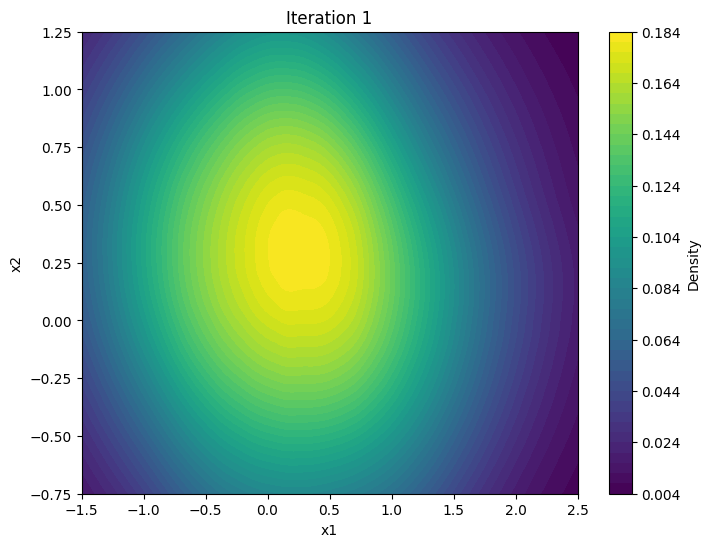

Epoch 200/1000, Loss: 1.1419


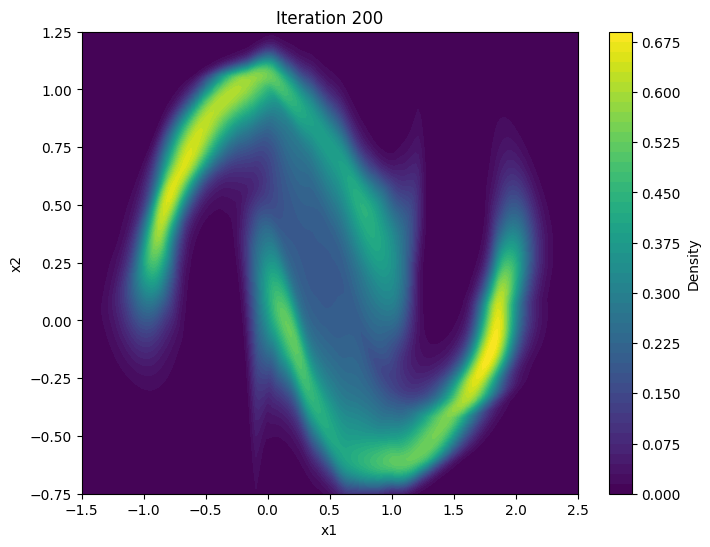

Epoch 400/1000, Loss: 1.1305


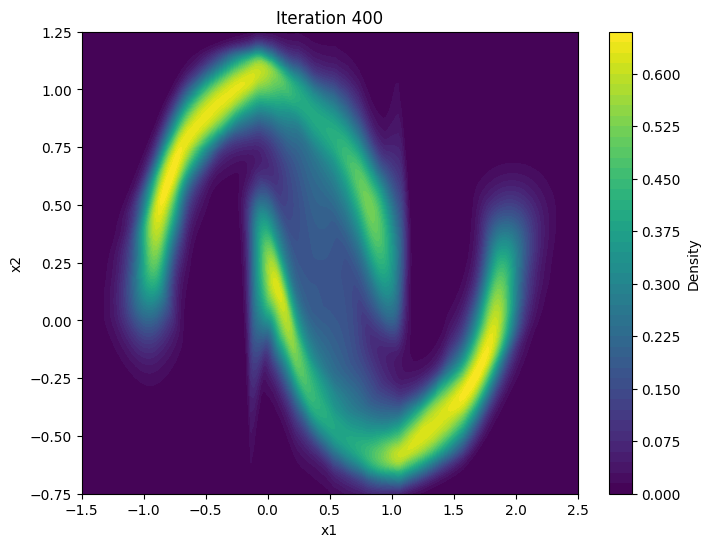

Epoch 600/1000, Loss: 1.1584


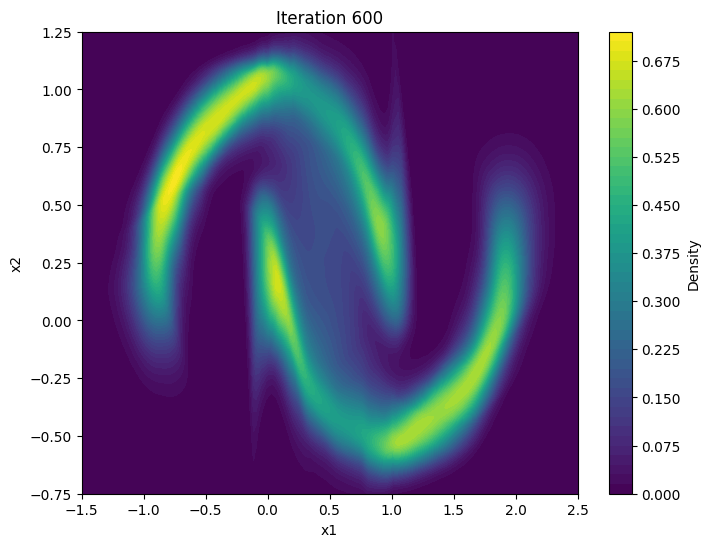

Epoch 800/1000, Loss: 1.1059


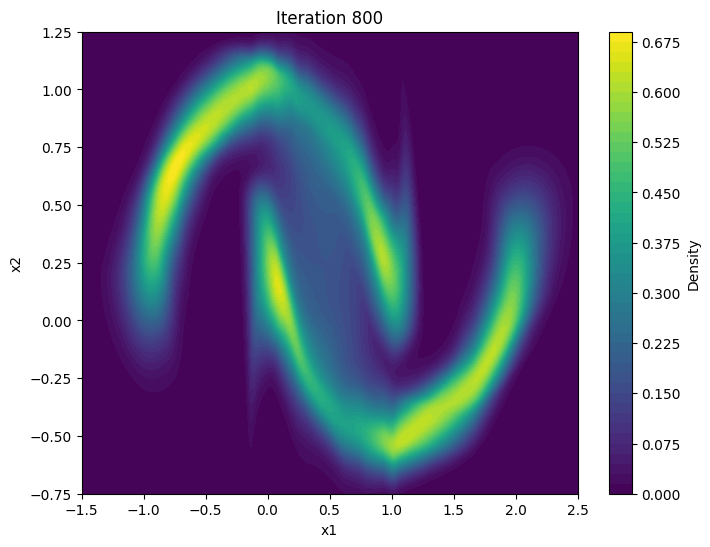

Epoch 1000/1000, Loss: 1.1565


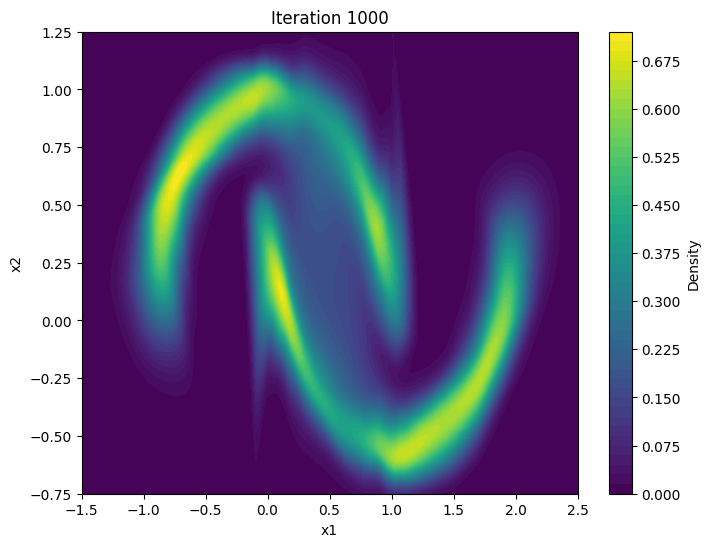

In [28]:
# Optimizer
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

# Training loop
for epoch in range(1, num_epochs + 1):
    # Generate batch data
    x, _ = make_moons(n_samples=batch_size, noise=0.1)
    x = torch.tensor(x, dtype=torch.float32).to(device)

    # Reset gradients
    optimizer.zero_grad()

    # Forward pass through the flow
    log_prob = flow.log_prob(x)  # Log-probabilities of x under the flow model
    loss = -log_prob.mean()      # Negative log-likelihood as the loss

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

        # Visualization of the learned density
        with torch.no_grad():
            xline = torch.linspace(-1.5, 2.5, 200, device=device)
            yline = torch.linspace(-0.75, 1.25, 200, device=device)
            xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
            xyinput = torch.cat([
                xgrid.reshape(-1, 1),
                ygrid.reshape(-1, 1)
            ], dim=1).to(device)

            # Compute log-probabilities for the grid points
            log_prob_grid = flow.log_prob(xyinput)
            zgrid = torch.exp(log_prob_grid).reshape(200, 200).cpu()

        # Plot density visualization
        plt.figure(figsize=(8, 6))
        plt.contourf(
            xgrid.cpu().numpy(),
            ygrid.cpu().numpy(),
            zgrid.numpy(),
            levels=50,
            cmap='viridis'
        )
        plt.title(f'Iteration {epoch}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.colorbar(label='Density')
        plt.show()

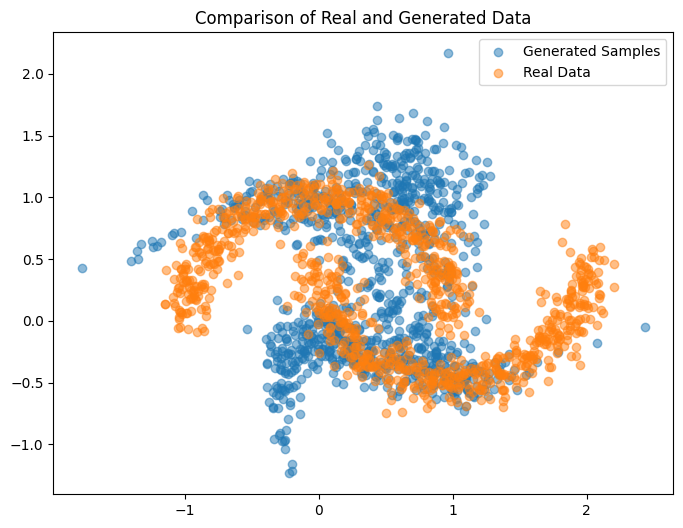

In [29]:
# Sampling from the flow
with torch.no_grad():
    samples = flow.sample(1000).cpu().numpy()
    x_real, _ = make_moons(1000, noise=0.1)

    plt.figure(figsize=(8, 6))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Generated Samples')
    plt.scatter(x_real[:, 0], x_real[:, 1], alpha=0.5, label='Real Data')
    plt.legend()
    plt.title('Comparison of Real and Generated Data')
    plt.show()

# Section 2:Flows In Action

Here, we show how a flow can be trained to generate images with the `normflows` package. The flow is a [Glow](https://arxiv.org/abs/1807.03039) model, which is based on the [multi-scale architecture](https://arxiv.org/abs/1605.08803). This Glow model is applied to the MNIST dataset.

## Perparation

To get started, we have to install the `normflows` package.

In [30]:
!pip install normflows

In [1]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm
import os

Glow consists of `nf.flows.GlowBlocks`, that are arranged in a `nf.MultiscaleFlow`, following the multi-scale architecture. The base distribution is a `nf.distributions.DiagGaussian`, which is a diagonal Gaussian.

In [2]:
# Define the directory to save checkpoints
checkpoint_dir = 'C:/Users/asus/Downloads/Compressed/DGM_HW3_Practical'
os.makedirs(checkpoint_dir, exist_ok=True)

In [5]:
# Set up model (nothing TODO here)

# Define flows
L = 2
K = 16
torch.manual_seed(0)

input_shape = (1, 28, 28)
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 128
split_mode = 'channel'
scale = True

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i),
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L,
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.DiagGaussian(latent_shape)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_tensor.py:857: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2000.)
  LU, pivots, infos = torch._lu_with_info(


In [7]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [3]:
# @title loading MNIST dataset with TorchVision

batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                                  #  nf.utils.Scale(255. / 256.),
                                   nf.utils.Jitter(1 / 256.)])

train_data = tv.datasets.MNIST('datasets/', train=True,
                                 download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                           drop_last=True)

test_data = tv.datasets.MNIST('datasets/', train=False,
                                download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Training

Now, can train the model on the image data. you can change this code to your prefered style as long as it is correct and the result is reasonable.

In [6]:
# Train model
max_iter = 10000
save_every = 2000  # Save every 2000 iterations

# Initialize loss history
loss_hist = np.array([])

# Optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr=5e-4, weight_decay=1e-5)

# Create an iterator for the training loader
train_iter = iter(train_loader)

for i in tqdm(range(max_iter)):
    # Get a batch of data
    try:
        data, _ = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        data, _ = next(train_iter)

    data = data.to(device)  # Move data to GPU if available

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass through the model, computing Kullback-Leibler Divergence (KLD) loss
    loss = model.forward_kld(data)
    if (i + 1) % 1000 == 0:
        print(f"Iteration {i+1}, Loss: {loss.item()}")

    # Backpropagation
    loss.backward()
    
    # Optimizer step
    optimizer.step()

    # Save loss for plotting later
    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

    # Save checkpoint periodically
    if (i + 1) % save_every == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_iter_{i+1}.pth')
        torch.save({
            'iteration': i + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_hist': loss_hist,
        }, checkpoint_path)
        print(f'Checkpoint saved at iteration {i+1} to {checkpoint_path}')

 10%|█         | 1001/10000 [01:32<13:24, 11.18it/s]

Iteration 1000, Loss: -3112.732177734375


 20%|█▉        | 1999/10000 [03:04<12:27, 10.70it/s]

Iteration 2000, Loss: -3172.7177734375
Checkpoint saved at iteration 2000 to C:/Users/asus/Downloads/Compressed/DGM_HW3_Practical\model_iter_2000.pth


 30%|███       | 3000/10000 [04:36<10:17, 11.33it/s]

Iteration 3000, Loss: -3250.18359375


 40%|████      | 4000/10000 [06:07<10:43,  9.32it/s]

Iteration 4000, Loss: -3263.77197265625
Checkpoint saved at iteration 4000 to C:/Users/asus/Downloads/Compressed/DGM_HW3_Practical\model_iter_4000.pth


 50%|█████     | 5000/10000 [07:39<06:59, 11.93it/s]

Iteration 5000, Loss: -3307.326171875


 60%|██████    | 6000/10000 [09:26<09:43,  6.85it/s]

Iteration 6000, Loss: -3359.27734375
Checkpoint saved at iteration 6000 to C:/Users/asus/Downloads/Compressed/DGM_HW3_Practical\model_iter_6000.pth


 70%|███████   | 7001/10000 [11:17<04:56, 10.10it/s]

Iteration 7000, Loss: -3329.17236328125


 80%|████████  | 8000/10000 [13:03<04:16,  7.80it/s]

Iteration 8000, Loss: -3356.2041015625
Checkpoint saved at iteration 8000 to C:/Users/asus/Downloads/Compressed/DGM_HW3_Practical\model_iter_8000.pth


 90%|█████████ | 9001/10000 [14:37<01:30, 11.02it/s]

Iteration 9000, Loss: -3404.84033203125


100%|██████████| 10000/10000 [16:08<00:00, 10.33it/s]

Iteration 10000, Loss: -3407.691162109375
Checkpoint saved at iteration 10000 to C:/Users/asus/Downloads/Compressed/DGM_HW3_Practical\model_iter_10000.pth


In [7]:
# Save the final model after training
final_checkpoint_path = os.path.join(checkpoint_dir, 'model_final.pth')
torch.save({
    'iteration': max_iter,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_hist': loss_hist,
}, final_checkpoint_path)
print(f'Final model saved to {final_checkpoint_path}')

Final model saved to C:/Users/asus/Downloads/Compressed/DGM_HW3_Practical\model_final.pth


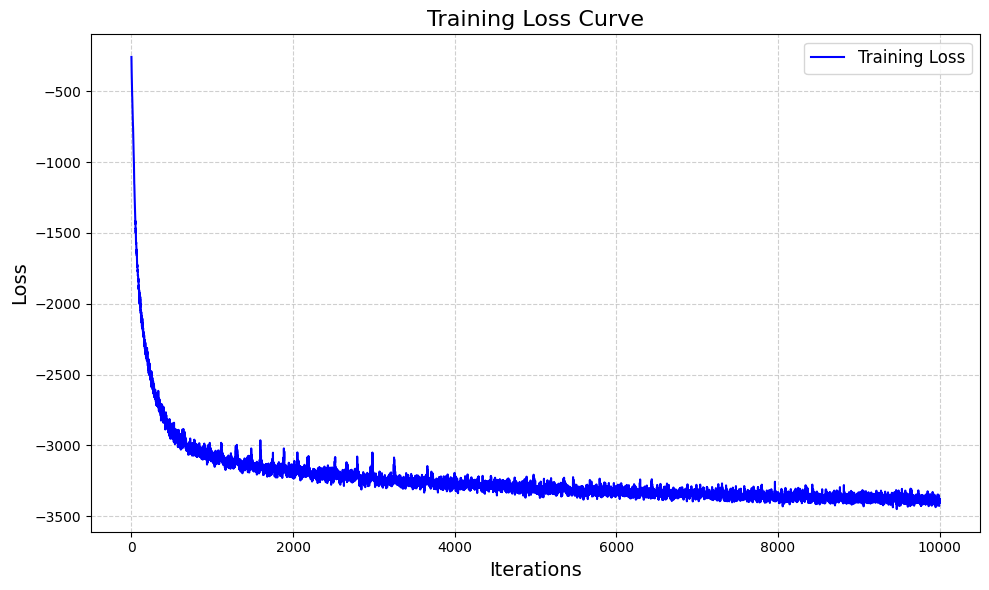

In [8]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_hist, label="Training Loss", color="blue")
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training Loss Curve", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
# Load the checkpoint
checkpoint_path = 'C:/Users/asus/Downloads/Compressed/DGM_HW3_Practical/model_final.pth'

# Initialize the model architecture
# This assumes you have already defined `model` with the same architecture as used during saving
model = nf.MultiscaleFlow(q0, flows, merges).to(device)  # Ensure the model is on the correct device (GPU or CPU)

# Initialize the optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load model state
model.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state (optional, if you want to resume training)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Load iteration count (if you want to resume from a specific iteration)
start_iter = checkpoint['iteration']

# Load the loss history (optional, for further analysis)
loss_hist = checkpoint['loss_hist']

print(f"Model loaded from {checkpoint_path}, starting at iteration {start_iter}")

C:\Users\asus\AppData\Local\Temp\ipykernel_27448\3687979027.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model loaded from C:/Users/asus/Downloads/Compressed/DGM_HW3_Practical/model_final.pth, starting at iteration 10000


## Evaluation

To evaluate our model, we can just draw samples from our model.

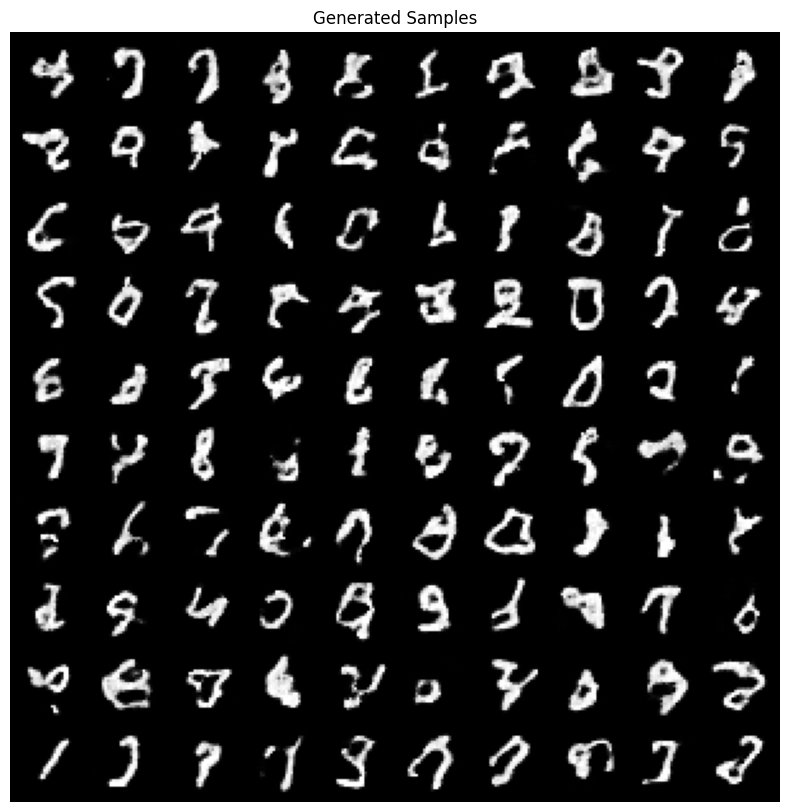

In [9]:
# Model samples
num_samples_per_grid = 10  # Number of samples per grid row
total_samples = num_samples_per_grid * num_samples_per_grid  # Total samples to generate


with torch.no_grad():
    # Sample from the base distribution
    x, _ = model.sample(num_samples_per_grid ** 2)  # No class labels needed
    x_ = torch.clamp(x, 0, 1)

    # Arrange samples in a grid
    grid = tv.utils.make_grid(x_, nrow=num_samples_per_grid)

    # Plot the grid of samples
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Generated Samples')
    plt.show()

Note that to get competitive performance, a much larger model than specified in this notebook, which is trained over more iterations, is needed.

## In-Painting

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim

Now you are supposed to create a function that masks a random square of the image, and a function that fills the missing part based on maximum liklihood using the trained flow model.

In [21]:
def apply_random_square_mask(image, mask_size=8):
    """
    Applies a random square mask to the input image.
    
    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        mask_size (int): Size of the square mask.
        
    Returns:
        masked_image (torch.Tensor): Image with the masked square.
        mask (torch.Tensor): Binary mask indicating masked regions (1 for masked) [H, W].
    """
    _, H, W = image.shape
    masked_image = image.clone()
    
    # Randomly sample the top-left corner of the square mask
    top_left_x = np.random.randint(0, W - mask_size + 1)
    top_left_y = np.random.randint(0, H - mask_size + 1)

    # Create a 2D mask: 1 where the region is masked, 0 otherwise
    mask = torch.zeros((H, W), dtype=torch.float32)
    mask[top_left_y:top_left_y + mask_size, top_left_x:top_left_x + mask_size] = 1

    # Apply the mask to the image (fill the masked region with 0s)
    masked_image[:, mask == 1] = 0

    return masked_image, mask

In [12]:
def fill_missing_part(masked_image, mask, model):
    """
    Fills the missing part of the image using the trained flow model based on maximum likelihood.
    
    Args:
        masked_image (torch.Tensor): Image with missing parts (masked).
        mask (torch.Tensor): Binary mask indicating masked regions (1 for masked).
        model (nf.MultiscaleFlow): Trained flow model.
        
    Returns:
        completed_image (torch.Tensor): Image with missing parts filled in.
    """
    # Flatten the image for the model input
    original_shape = masked_image.shape
    masked_image_flat = masked_image.view(1, -1)  # Shape [1, C*H*W]
    
    # Get the log likelihood of the image under the flow model
    with torch.no_grad():
        # Infer the latent variable for the observed (unmasked) part
        z, _ = model.forward(masked_image_flat)
        
        # Reconstruct the image using maximum likelihood
        reconstructed_image_flat = model.inverse(z)[0]
    
    # Reshape back to the original image shape
    reconstructed_image = reconstructed_image_flat.view(original_shape)
    
    # Combine the reconstructed part with the unmasked parts
    completed_image = masked_image.clone()
    completed_image[mask == 1] = reconstructed_image[mask == 1]

    return completed_image

In [19]:
# @title Optional random noise mask
def apply_random_noise_mask(image, noise_fraction=0.2):
    """
    Applies a random noise mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        noise_fraction (float): Fraction of pixels to replace with noise.

    Returns:
        masked_image (torch.Tensor): Image with noise added.
        mask (torch.Tensor): Binary mask indicating noise regions (1 for noise).
    """
    masked_image = image.clone()
    mask = torch.zeros_like(image[0])  # Single channel mask

    C, H, W = image.shape
    num_pixels = H * W
    num_noise = int(noise_fraction * num_pixels)

    # Random indices
    noise_indices = np.random.choice(num_pixels, num_noise, replace=False)
    noise_coords = np.unravel_index(noise_indices, (H, W))

    # Apply noise
    for c in range(C):
        noise = torch.rand(num_noise) * 2 - 1  # Random noise in [-1, 1]
        masked_image[c, noise_coords[0], noise_coords[1]] = noise
    mask[noise_coords[0], noise_coords[1]] = 1.0

    return masked_image, mask

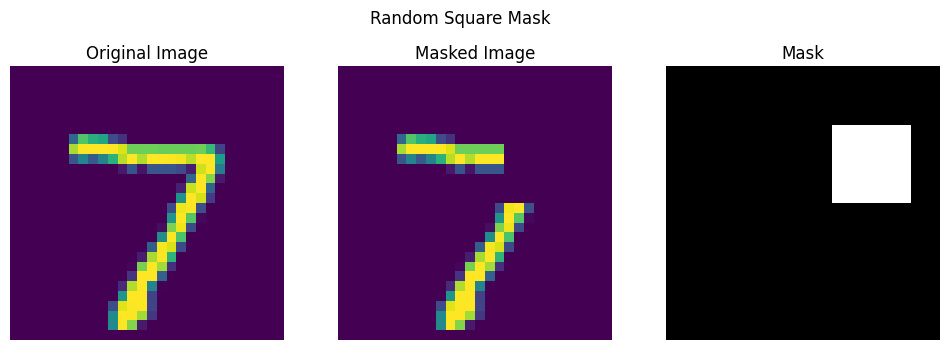

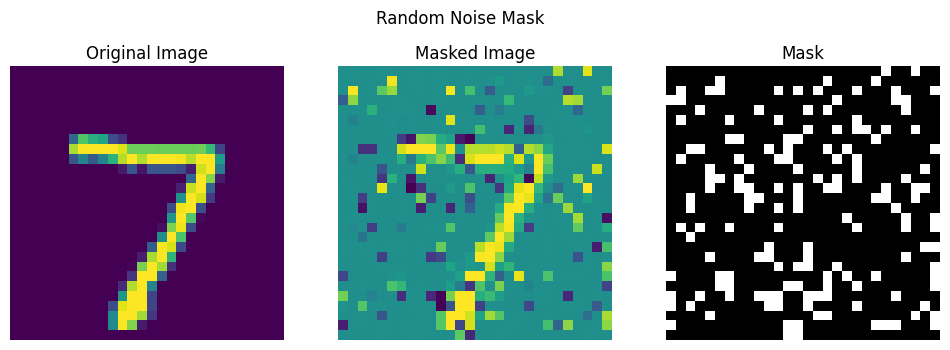

In [22]:
def visualize_masking(original_image, masked_image, mask, title="Masking Example"):
    """
    Visualizes the original, masked images and the mask.

    Args:
        original_image (torch.Tensor): Original image tensor [C, H, W].
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask [H, W].
        title (str): Title for the plot.
    """
    original = original_image.permute(1, 2, 0).cpu().numpy()
    masked = masked_image.permute(1, 2, 0).cpu().numpy()
    mask_display = mask.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(masked)
    axs[1].set_title("Masked Image")
    axs[1].axis('off')

    axs[2].imshow(mask_display, cmap='gray')
    axs[2].set_title("Mask")
    axs[2].axis('off')

    plt.suptitle(title)
    plt.show()

# Example usage
# Assuming `sample_image` is a tensor [C, H, W] from your dataset
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0]  # Take the first image

masked_image_square, mask_square = apply_random_square_mask(sample_image, mask_size=8)
visualize_masking(sample_image, masked_image_square, mask_square, title="Random Square Mask")

masked_image_noise, mask_noise = apply_random_noise_mask(sample_image, noise_fraction=0.2)
visualize_masking(sample_image, masked_image_noise, mask_noise, title="Random Noise Mask")

In [25]:
def inpaint_image(model, masked_image, mask, device, num_steps=1000, lr=0.1):
    """
    Inpaints the masked regions of an image by maximizing the log-likelihood under the flow model.

    Args:
        model (nn.Module): Trained normalizing flow model.
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask tensor [H, W], 1 for masked pixels.
        device (torch.device): Device for computations.
        num_steps (int): Number of optimization steps.
        lr (float): Learning rate for the optimizer.

    Returns:
        inpainted_image (torch.Tensor): Inpainted image tensor [C, H, W].
    """
    model.eval()  # Set model to evaluation mode

    # Clone the masked image to avoid modifying the original
    inpainted_image = masked_image.clone().to(device).unsqueeze(0)  # Shape [1, C, H, W]
    mask = mask.unsqueeze(0).unsqueeze(0).to(device)  # Shape [1, 1, H, W]

    # Initialize the missing pixels to zeros initially (can also use random noise)
    missing_pixels = torch.zeros_like(inpainted_image).to(device)
    
    # Use the mask to retain only masked pixels for optimization
    missing_pixels = torch.nn.Parameter(missing_pixels)  # Learnable parameter

    # Define optimizer to optimize the missing pixels
    optimizer = optim.Adam([missing_pixels], lr=lr)

    for step in tqdm(range(num_steps), desc="Inpainting"):
        optimizer.zero_grad()

        # Combine the masked and unmasked pixels into one image
        current_image = inpainted_image * (1 - mask) + missing_pixels * mask

        # Forward pass through the model (use the normalizing flow model to calculate log-likelihood)
        loss = model.forward_kld(current_image)

        # Backpropagate the error to optimize the missing pixels
        loss.backward()

        # Update missing pixels
        optimizer.step()

        # Clamp the missing pixels to valid range (e.g., [0, 1] for MNIST-like images)
        with torch.no_grad():
            missing_pixels.data.clamp_(0, 1)

        # Print loss every 100 steps
        if (step + 1) % 100 == 0:
            print(f"Step [{step+1}/{num_steps}], Loss: {loss.item():.4f}")

    # After optimization, combine the final inpainted image
    inpainted_image = inpainted_image * (1 - mask) + missing_pixels * mask

    return inpainted_image.squeeze(0)  # Return the inpainted image without the batch dimension

In [27]:
# Example usage with a batch of 4 images
batch_size = 4
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:batch_size]
sample_labels = sample_labels[:batch_size]

# Apply random square masks to the batch
masked_images = []
masks = []
inpainted_images = []

for img in sample_images:
    masked_img, mask = apply_random_square_mask(img, mask_size=8)
    masked_images.append(masked_img)
    masks.append(mask)
    inpainted_images.append(inpaint_image(model, masked_img, mask, device, num_steps=1000, lr=0.1))

masked_images = torch.stack(masked_images)
masks = torch.stack(masks)
inpainted_images = torch.stack(inpainted_images)

Inpainting:   0%|          | 0/1000 [00:00<?, ?it/s]

Inpainting:  10%|█         | 102/1000 [00:06<01:01, 14.72it/s]

Step [100/1000], Loss: -3420.0830


Inpainting:  20%|██        | 202/1000 [00:13<00:53, 14.82it/s]

Step [200/1000], Loss: -3435.5786


Inpainting:  30%|███       | 302/1000 [00:21<00:54, 12.79it/s]

Step [300/1000], Loss: -3442.7666


Inpainting:  40%|████      | 402/1000 [00:28<00:41, 14.39it/s]

Step [400/1000], Loss: -3436.2888


Inpainting:  50%|█████     | 502/1000 [00:35<00:35, 14.16it/s]

Step [500/1000], Loss: -3442.6333


Inpainting:  60%|██████    | 602/1000 [00:41<00:27, 14.33it/s]

Step [600/1000], Loss: -3448.1313


Inpainting:  70%|███████   | 702/1000 [00:48<00:19, 14.95it/s]

Step [700/1000], Loss: -3462.5918


Inpainting:  80%|████████  | 802/1000 [00:55<00:13, 15.18it/s]

Step [800/1000], Loss: -3452.8979


Inpainting:  90%|█████████ | 902/1000 [01:02<00:06, 15.01it/s]

Step [900/1000], Loss: -3443.2769


Inpainting: 100%|██████████| 1000/1000 [01:09<00:00, 14.48it/s]


Step [1000/1000], Loss: -3454.4636


Inpainting:  10%|█         | 102/1000 [00:07<01:05, 13.74it/s]

Step [100/1000], Loss: -3130.9658


Inpainting:  20%|██        | 202/1000 [00:14<01:00, 13.09it/s]

Step [200/1000], Loss: -3164.8916


Inpainting:  30%|███       | 301/1000 [00:25<01:05, 10.64it/s]

Step [300/1000], Loss: -3180.3750


Inpainting:  40%|████      | 401/1000 [00:34<00:51, 11.73it/s]

Step [400/1000], Loss: -3188.1782


Inpainting:  50%|█████     | 501/1000 [00:44<00:44, 11.11it/s]

Step [500/1000], Loss: -3196.3301


Inpainting:  60%|██████    | 601/1000 [00:52<00:31, 12.57it/s]

Step [600/1000], Loss: -3183.7412


Inpainting:  70%|███████   | 701/1000 [00:59<00:21, 14.04it/s]

Step [700/1000], Loss: -3194.8574


Inpainting:  80%|████████  | 801/1000 [01:08<00:16, 12.15it/s]

Step [800/1000], Loss: -3194.6230


Inpainting:  90%|█████████ | 901/1000 [01:16<00:07, 12.52it/s]

Step [900/1000], Loss: -3162.5752


Inpainting: 100%|██████████| 1000/1000 [01:25<00:00, 11.67it/s]


Step [1000/1000], Loss: -3140.0730


Inpainting:  10%|█         | 101/1000 [00:08<01:09, 12.96it/s]

Step [100/1000], Loss: -3626.5635


Inpainting:  20%|██        | 201/1000 [00:16<01:03, 12.61it/s]

Step [200/1000], Loss: -3658.5183


Inpainting:  30%|███       | 301/1000 [00:24<00:51, 13.55it/s]

Step [300/1000], Loss: -3657.5283


Inpainting:  40%|████      | 403/1000 [00:32<00:46, 12.93it/s]

Step [400/1000], Loss: -3669.2888


Inpainting:  50%|█████     | 503/1000 [00:40<00:31, 15.82it/s]

Step [500/1000], Loss: -3686.8379


Inpainting:  60%|██████    | 601/1000 [00:46<00:33, 12.03it/s]

Step [600/1000], Loss: -3693.8003


Inpainting:  70%|███████   | 701/1000 [00:54<00:24, 12.36it/s]

Step [700/1000], Loss: -3676.6863


Inpainting:  80%|████████  | 801/1000 [01:03<00:15, 12.57it/s]

Step [800/1000], Loss: -3686.7324


Inpainting:  90%|█████████ | 901/1000 [01:10<00:08, 11.64it/s]

Step [900/1000], Loss: -3672.6772


Inpainting: 100%|██████████| 1000/1000 [01:18<00:00, 12.76it/s]


Step [1000/1000], Loss: -3693.0312


Inpainting:  10%|█         | 102/1000 [00:07<01:06, 13.55it/s]

Step [100/1000], Loss: -3078.4792


Inpainting:  20%|██        | 202/1000 [00:15<01:08, 11.59it/s]

Step [200/1000], Loss: -3103.6345


Inpainting:  30%|███       | 302/1000 [00:24<00:57, 12.14it/s]

Step [300/1000], Loss: -3052.3232


Inpainting:  40%|████      | 402/1000 [00:32<00:47, 12.62it/s]

Step [400/1000], Loss: -3075.3176


Inpainting:  50%|█████     | 502/1000 [00:40<00:34, 14.54it/s]

Step [500/1000], Loss: -3115.3831


Inpainting:  60%|██████    | 602/1000 [00:47<00:33, 11.96it/s]

Step [600/1000], Loss: -3111.9707


Inpainting:  70%|███████   | 702/1000 [00:54<00:19, 14.98it/s]

Step [700/1000], Loss: -3110.8179


Inpainting:  80%|████████  | 802/1000 [01:02<00:15, 12.88it/s]

Step [800/1000], Loss: -3120.2429


Inpainting:  90%|█████████ | 902/1000 [01:10<00:06, 14.47it/s]

Step [900/1000], Loss: -3103.1614


Inpainting: 100%|██████████| 1000/1000 [01:16<00:00, 13.12it/s]

Step [1000/1000], Loss: -3109.2085


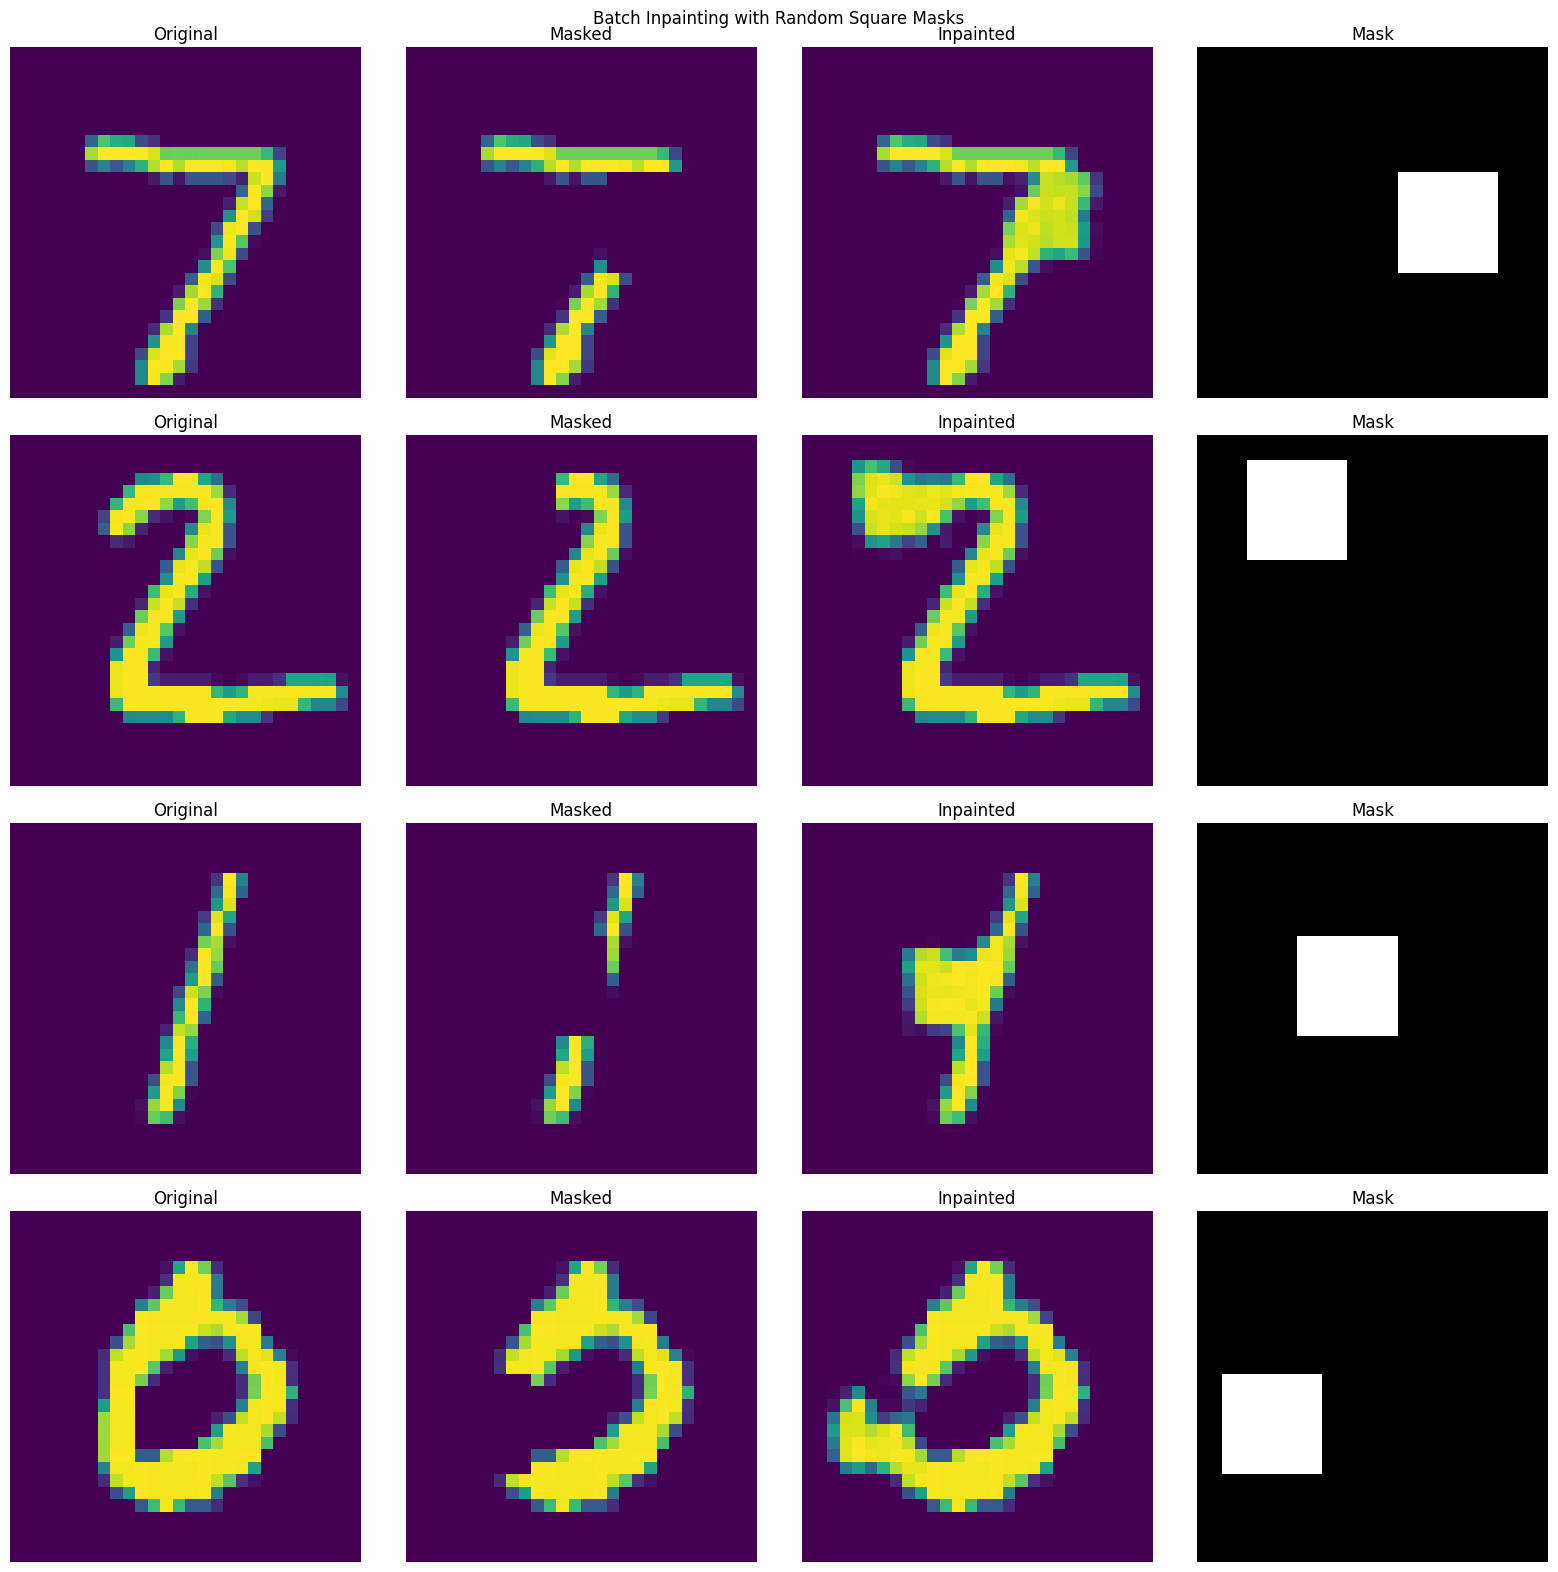

In [28]:
# Visualize the results (this is a suggested code, you can change this)
def visualize_batch_inpainting(originals, masked, inpainted, masks, title="Batch Inpainting Results"):
    """
    Visualizes a batch of original, masked, and inpainted images with their masks.

    Args:
        originals (torch.Tensor): Original images [N, C, H, W].
        masked (torch.Tensor): Masked images [N, C, H, W].
        inpainted (torch.Tensor): Inpainted images [N, C, H, W].
        masks (torch.Tensor): Masks [N, H, W].
        title (str): Title for the plot.
    """
    N = originals.size(0)
    fig, axs = plt.subplots(N, 4, figsize=(16, 4 * N))

    for i in range(N):

        original = originals[i].permute(1, 2, 0).detach().cpu().numpy()
        masked_img = masked[i].permute(1, 2, 0).detach().cpu().numpy()
        inpainted_img = inpainted[i].permute(1, 2, 0).detach().cpu().numpy()
        mask_display = masks[i].detach().cpu().numpy()

        axs[i, 0].imshow(original)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(masked_img)
        axs[i, 1].set_title("Masked")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(inpainted_img)
        axs[i, 2].set_title("Inpainted")
        axs[i, 2].axis('off')

        axs[i, 3].imshow(mask_display, cmap='gray')
        axs[i, 3].set_title("Mask")
        axs[i, 3].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_batch_inpainting(sample_images, masked_images, inpainted_images, masks, title="Batch Inpainting with Random Square Masks")


In [30]:
# Example usage with a batch of 4 images
batch_size = 4
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:batch_size]
sample_labels = sample_labels[:batch_size]

# Apply random noise masks to the batch
masked_images = []
masks = []
inpainted_images = []

for img in sample_images:
    # Apply random noise mask instead of square mask
    masked_img, mask = apply_random_noise_mask(img, noise_fraction=0.2)  # Adjust noise fraction as needed
    masked_images.append(masked_img)
    masks.append(mask)
    
    # Inpaint the noisy image using the inpainting function
    inpainted_images.append(inpaint_image(model, masked_img, mask, device, num_steps=1000, lr=0.01))

# Stack the results into batches
masked_images = torch.stack(masked_images)
masks = torch.stack(masks)
inpainted_images = torch.stack(inpainted_images)

Inpainting:  10%|█         | 102/1000 [00:06<01:00, 14.77it/s]

Step [100/1000], Loss: -3553.5850


Inpainting:  20%|██        | 202/1000 [00:13<00:50, 15.80it/s]

Step [200/1000], Loss: -3601.7742


Inpainting:  30%|███       | 302/1000 [00:19<00:42, 16.33it/s]

Step [300/1000], Loss: -3633.9475


Inpainting:  40%|████      | 402/1000 [00:25<00:36, 16.31it/s]

Step [400/1000], Loss: -3627.3462


Inpainting:  50%|█████     | 502/1000 [00:31<00:30, 16.35it/s]

Step [500/1000], Loss: -3633.0120


Inpainting:  60%|██████    | 602/1000 [00:38<00:25, 15.89it/s]

Step [600/1000], Loss: -3634.6206


Inpainting:  70%|███████   | 702/1000 [00:44<00:18, 16.11it/s]

Step [700/1000], Loss: -3636.0222


Inpainting:  80%|████████  | 802/1000 [00:50<00:12, 16.49it/s]

Step [800/1000], Loss: -3634.3757


Inpainting:  90%|█████████ | 902/1000 [00:56<00:06, 16.16it/s]

Step [900/1000], Loss: -3633.8635


Inpainting: 100%|██████████| 1000/1000 [01:02<00:00, 15.96it/s]


Step [1000/1000], Loss: -3631.5845


Inpainting:  10%|█         | 102/1000 [00:06<01:06, 13.50it/s]

Step [100/1000], Loss: -3036.4932


Inpainting:  20%|██        | 202/1000 [00:13<00:54, 14.64it/s]

Step [200/1000], Loss: -3198.9849


Inpainting:  30%|███       | 302/1000 [00:20<00:48, 14.33it/s]

Step [300/1000], Loss: -3219.4883


Inpainting:  40%|████      | 402/1000 [00:27<00:40, 14.80it/s]

Step [400/1000], Loss: -3218.4395


Inpainting:  50%|█████     | 502/1000 [00:34<00:34, 14.42it/s]

Step [500/1000], Loss: -3220.8621


Inpainting:  60%|██████    | 602/1000 [00:41<00:28, 14.14it/s]

Step [600/1000], Loss: -3218.9094


Inpainting:  70%|███████   | 702/1000 [00:48<00:19, 14.93it/s]

Step [700/1000], Loss: -3219.2812


Inpainting:  80%|████████  | 802/1000 [00:55<00:13, 14.98it/s]

Step [800/1000], Loss: -3217.6082


Inpainting:  90%|█████████ | 902/1000 [01:01<00:06, 14.91it/s]

Step [900/1000], Loss: -3219.2571


Inpainting: 100%|██████████| 1000/1000 [01:08<00:00, 14.62it/s]


Step [1000/1000], Loss: -3217.7935


Inpainting:  10%|█         | 102/1000 [00:06<00:58, 15.25it/s]

Step [100/1000], Loss: -3779.6963


Inpainting:  20%|██        | 202/1000 [00:13<00:49, 16.13it/s]

Step [200/1000], Loss: -3796.6936


Inpainting:  30%|███       | 302/1000 [00:19<00:42, 16.24it/s]

Step [300/1000], Loss: -3813.3682


Inpainting:  40%|████      | 402/1000 [00:25<00:37, 15.78it/s]

Step [400/1000], Loss: -3809.6279


Inpainting:  50%|█████     | 502/1000 [00:31<00:33, 14.78it/s]

Step [500/1000], Loss: -3811.9443


Inpainting:  60%|██████    | 602/1000 [00:39<00:33, 11.73it/s]

Step [600/1000], Loss: -3809.2605


Inpainting:  70%|███████   | 701/1000 [00:48<00:27, 10.76it/s]

Step [700/1000], Loss: -3809.2759


Inpainting:  80%|████████  | 801/1000 [00:57<00:16, 11.84it/s]

Step [800/1000], Loss: -3812.2673


Inpainting:  90%|█████████ | 901/1000 [01:05<00:07, 12.40it/s]

Step [900/1000], Loss: -3810.8743


Inpainting: 100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]


Step [1000/1000], Loss: -3810.3354


Inpainting:  10%|█         | 100/1000 [00:07<01:15, 11.86it/s]

Step [100/1000], Loss: -3098.2854


Inpainting:  20%|██        | 202/1000 [00:15<00:49, 16.12it/s]

Step [200/1000], Loss: -3318.1667


Inpainting:  30%|███       | 302/1000 [00:23<00:58, 11.89it/s]

Step [300/1000], Loss: -3374.1572


Inpainting:  40%|████      | 400/1000 [00:31<00:45, 13.08it/s]

Step [400/1000], Loss: -3373.0667


Inpainting:  50%|█████     | 502/1000 [00:39<00:43, 11.45it/s]

Step [500/1000], Loss: -3375.8215


Inpainting:  60%|██████    | 600/1000 [00:47<00:32, 12.23it/s]

Step [600/1000], Loss: -3370.9502


Inpainting:  70%|███████   | 702/1000 [00:56<00:25, 11.72it/s]

Step [700/1000], Loss: -3370.1934


Inpainting:  80%|████████  | 800/1000 [01:04<00:17, 11.51it/s]

Step [800/1000], Loss: -3374.1333


Inpainting:  90%|█████████ | 902/1000 [01:13<00:08, 12.16it/s]

Step [900/1000], Loss: -3375.1323


Inpainting: 100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]

Step [1000/1000], Loss: -3369.3494


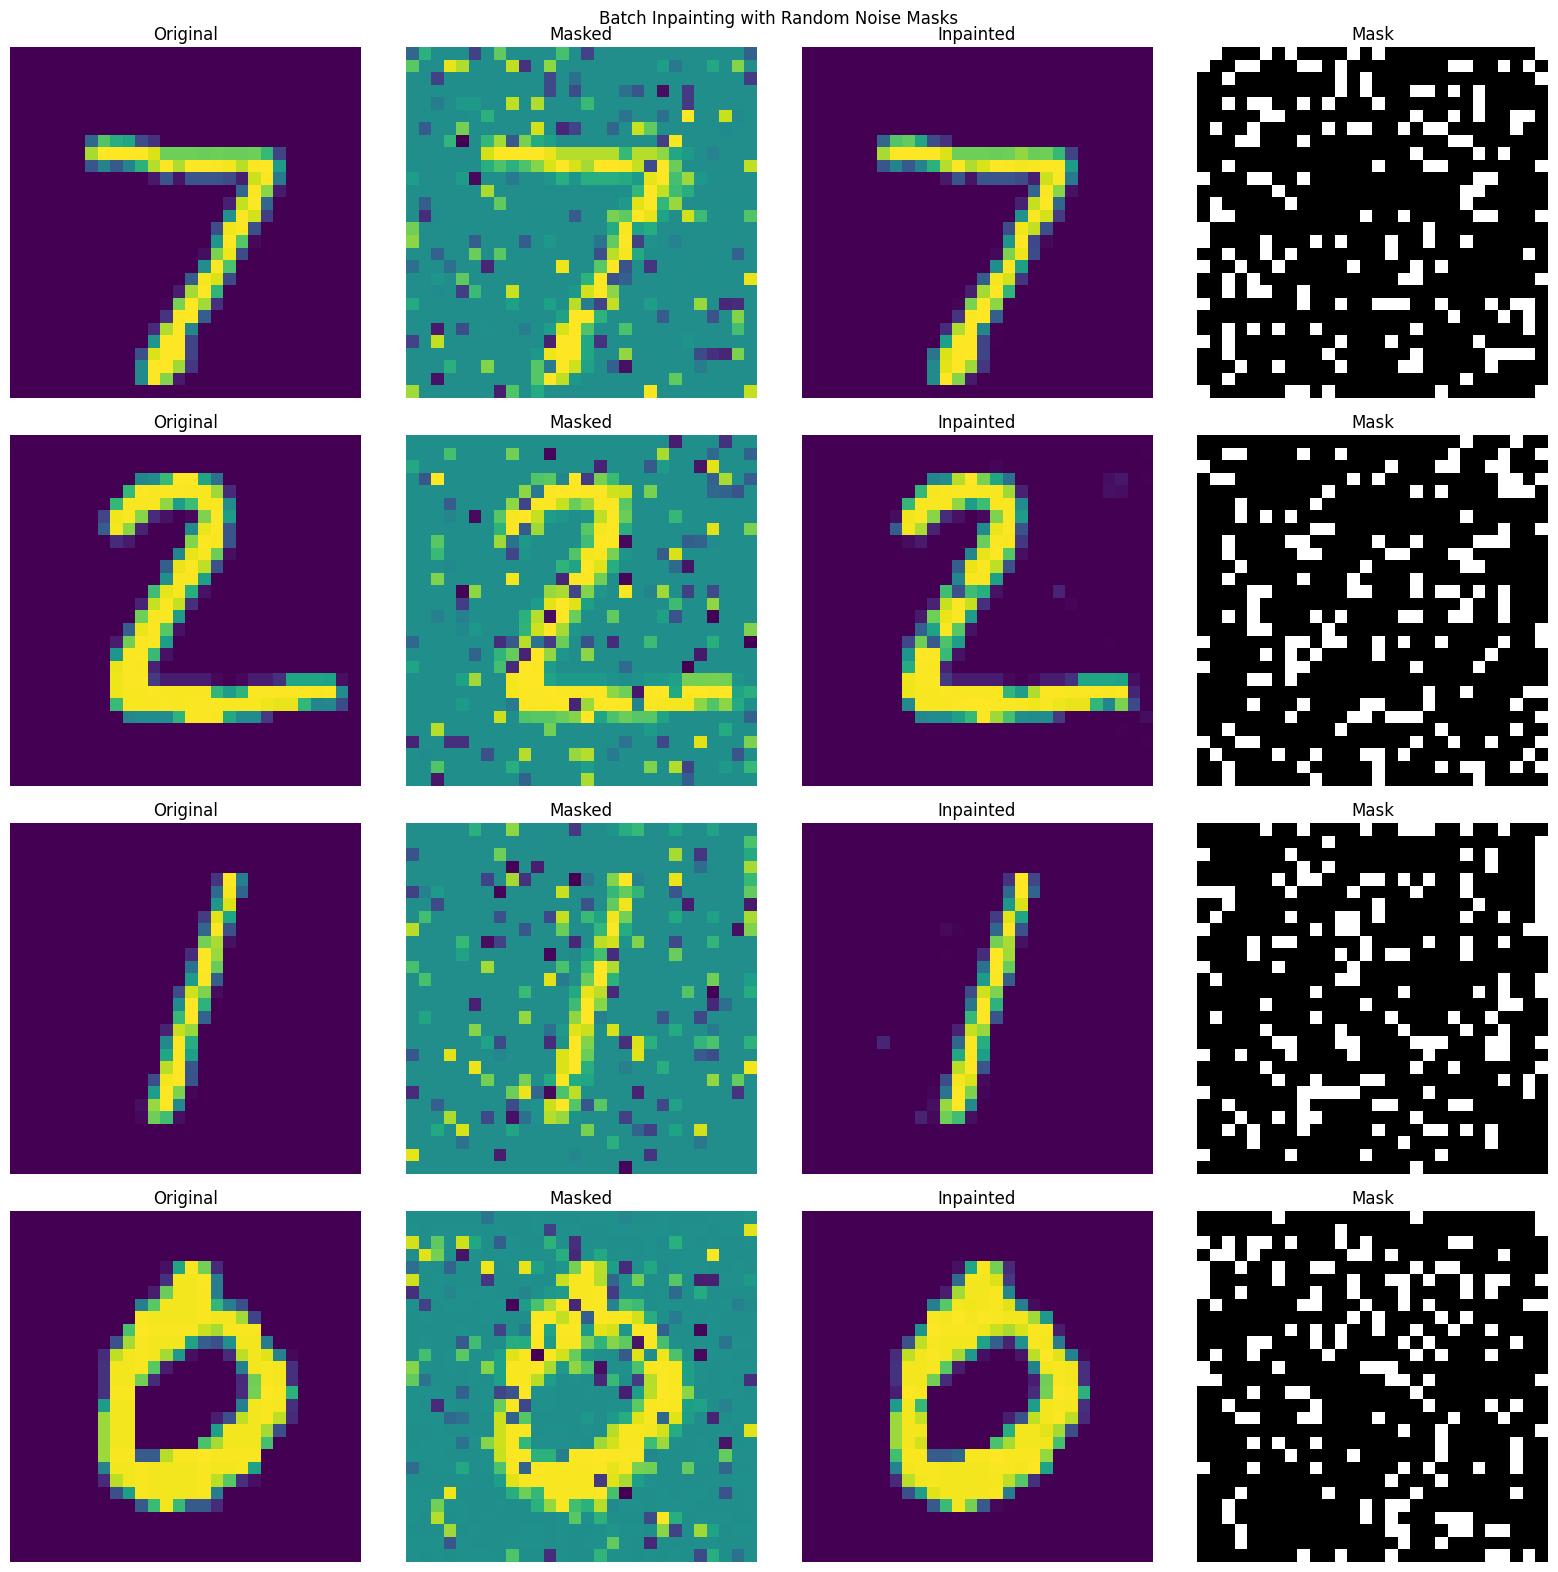

In [31]:
visualize_batch_inpainting(sample_images, masked_images, inpainted_images, masks, title="Batch Inpainting with Random Noise Masks")